In [0]:
#
# Part A Qn 2
#

import math
import tensorflow as tf
import numpy as np
import pylab as plt
import pickle



NUM_CLASSES = 10
IMG_SIZE = 32
NUM_CHANNELS = 3
learning_rate = 0.001
epochs = 1500
batch_size = 128


seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

def load_data(file):
    with open(file, 'rb') as fo:
        try:
            samples = pickle.load(fo)
        except UnicodeDecodeError:  # python 3.x
            fo.seek(0)
            samples = pickle.load(fo, encoding='latin1')

    data, labels = samples['data'], samples['labels']

    data = np.array(data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)
    no_of_patterns = labels.shape[0]
    
    # one hot encoding of labels
    # labels ranging from 0 to 9
    labels_onehot = np.zeros([no_of_patterns, NUM_CLASSES])
    labels_onehot[np.arange(no_of_patterns), labels] = 1

    return data, labels_onehot



def cnn(images, filters1, filters2):

    # channel first RGB images
    images = tf.reshape(images, [-1, NUM_CHANNELS, IMG_SIZE, IMG_SIZE])
    # convert to channel last
    images = tf.transpose(images, perm=[0,2,3,1])
    
    # Conv 1
    W1 = tf.Variable(tf.truncated_normal([9, 9, NUM_CHANNELS, filters1], 
                                         stddev = 1.0 / np.sqrt(NUM_CHANNELS * 9 * 9)), 
                     name='weights_1')
    b1 = tf.Variable(tf.zeros([filters1]), name='biases_1')
    conv_1 = tf.nn.relu(tf.nn.conv2d(images, W1, [1, 1, 1, 1], padding='VALID') + b1)

    # Pool 1
    pool_1 = tf.nn.max_pool(conv_1, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], 
                            padding='VALID', name='pool_1')

    # Conv 2
    W2 = tf.Variable(tf.truncated_normal([5, 5, filters1, filters2], 
                                         stddev = 1.0 / np.sqrt(filters1 * 5 * 5)), 
                     name='weights_2')
    b2 = tf.Variable(tf.zeros([filters2]), name='biases_2')
    conv_2 = tf.nn.relu(tf.nn.conv2d(pool_1, W2, [1, 1, 1, 1], padding='VALID') + b2)

    # Pool 2
    pool_2 = tf.nn.max_pool(conv_2, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], 
                            padding='VALID', name='pool_2')
    # Flatten
    #print('shape at pool_2:', pool_2.shape)
    dim = pool_2.shape[1].value * pool_2.shape[2].value * pool_2.shape[3].value
    pool_2_flat = tf.reshape(pool_2, [-1, dim])
	
    # Fully connected layer
    W_fc1 = tf.Variable(tf.truncated_normal([dim, 300], stddev=1.0/np.sqrt(dim)), 
                        name='weights_fc1')
    b_fc1 = tf.Variable(tf.zeros([300]), name='biases_fc1')
    h_fc1 = tf.nn.relu(tf.matmul(pool_2_flat, W_fc1) + b_fc1)

    # Softmax
    W_fc2 = tf.Variable(tf.truncated_normal([300, NUM_CLASSES], stddev=1.0/np.sqrt(300)), 
                        name='weights_fc2')
    b_fc2 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_fc2')
    logits = tf.matmul(h_fc1, W_fc2) + b_fc2

    return conv_1, pool_1, conv_2, pool_2, logits


In [0]:
# Load in data

trainX, trainY = load_data('data_batch_1')
print('Training data shape:', trainX.shape, trainY.shape)

testX, testY = load_data('test_batch_trim')
print('Test data shape:', testX.shape, testY.shape)

# Scale the images
min_trainX = np.min(trainX, axis = 0)
max_trainX = np.max(trainX, axis = 0)
trainX = (trainX - min_trainX) / max_trainX
testX = (testX - min_trainX) / max_trainX

Training data shape: (10000, 3072) (10000, 10)
Test data shape: (2000, 3072) (2000, 10)


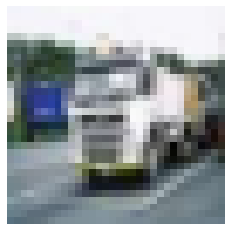

In [0]:
# Visualise the data
# The documentation writes: The first 1024 entries contain the red channel values, the next 1024 
# the green, and the final 1024 the blue. Hence, reshape to (NUM_CHANNELS, IMG_SIZE, IMG_SIZE).
X = trainX[1000].reshape(NUM_CHANNELS, IMG_SIZE, IMG_SIZE)

plt.figure()
plt.gray()
plt.axis('off')
plt.imshow(X.transpose(1,2,0))

In [0]:
# Create the model
x = tf.placeholder(tf.float32, [None, IMG_SIZE * IMG_SIZE * NUM_CHANNELS])
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

def grid_search_cnn(x, filters1, filters2):
    conv_1, pool_1, conv_2, pool_2, logits = cnn(x, filters1, filters2)

    # Loss function
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
    loss = tf.reduce_mean(cross_entropy)

    # Optimiser
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    # Accuracy
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

    return conv_1, pool_1, conv_2, pool_2, loss, train_step, accuracy


In [0]:
# Training

# Define search space
num_filters = [32, 64, 128, 256]

N = len(trainX)
idx = np.arange(N)

parameters = []
train_loss_all = []
test_acc_all =[]

for filters1 in num_filters:
    for filters2 in num_filters:
        # Record down the parameters used
        parameters.append((filters1, filters2))
        print('\nNo of filters at conv_1 (C1):', filters1, \
              ', no of filters at conv_2 (C2):', filters2)
        
        # Build CNN
        conv_1, pool_1, conv_2, pool_2, loss, train_step, accuracy = grid_search_cnn(x, filters1, filters2)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            train_loss = []
            test_acc = []
            for e in range(epochs):
                np.random.shuffle(idx)
                trainX, trainY = trainX[idx], trainY[idx]
                
                # Mini batch learning
                for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
                    train_step.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})

                train_loss.append(loss.eval(feed_dict={x: trainX, y_: trainY}))
                test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))

                if e % 100 == 0:
                    print('iter', e, '--- train cost:', train_loss[e], ', test accuracy:', test_acc[e])

        train_loss_all.append(train_loss)
        test_acc_all.append(test_acc)


No of filters at conv_1 (C1): 32 , no of filters at conv_2 (C2): 32
iter 0 --- train cost: 2.2983546 , test accuracy: 0.1235
iter 100 --- train cost: 1.7689264 , test accuracy: 0.3555
iter 200 --- train cost: 1.5345201 , test accuracy: 0.4385
iter 300 --- train cost: 1.4175203 , test accuracy: 0.4795
iter 400 --- train cost: 1.3176539 , test accuracy: 0.511
iter 500 --- train cost: 1.2237127 , test accuracy: 0.52
iter 600 --- train cost: 1.1365701 , test accuracy: 0.544
iter 700 --- train cost: 1.0648797 , test accuracy: 0.5535
iter 800 --- train cost: 0.97021806 , test accuracy: 0.564
iter 900 --- train cost: 0.8801789 , test accuracy: 0.577
iter 1000 --- train cost: 0.8224035 , test accuracy: 0.5595
iter 1100 --- train cost: 0.7403578 , test accuracy: 0.566
iter 1200 --- train cost: 0.6297182 , test accuracy: 0.5765
iter 1300 --- train cost: 0.5661422 , test accuracy: 0.574
iter 1400 --- train cost: 0.5177873 , test accuracy: 0.5615

No of filters at conv_1 (C1): 32 , no of filters 

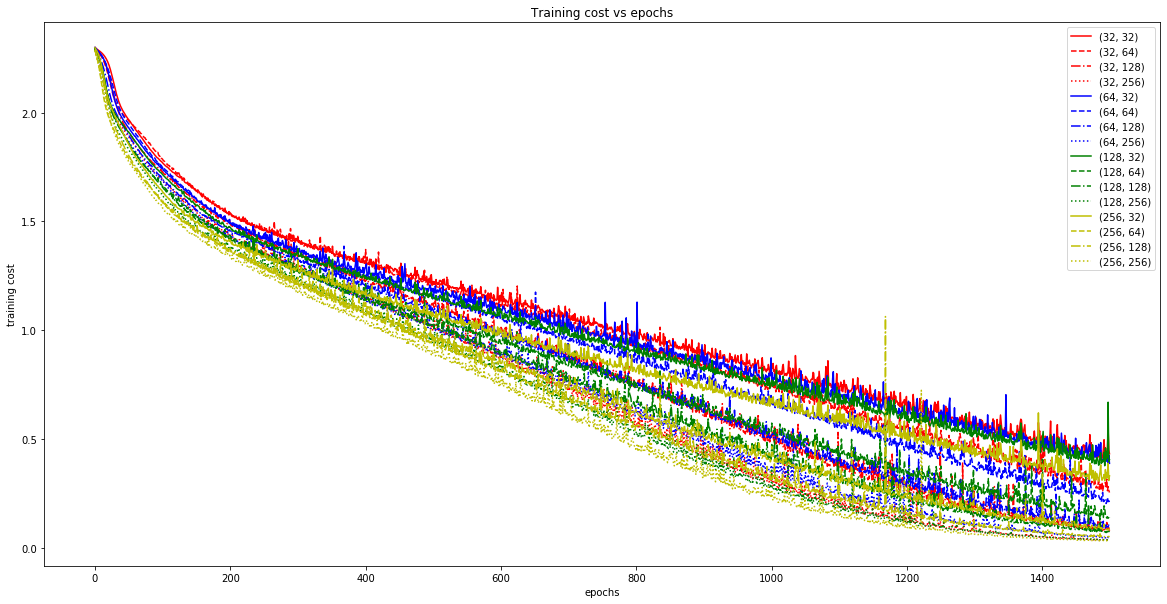

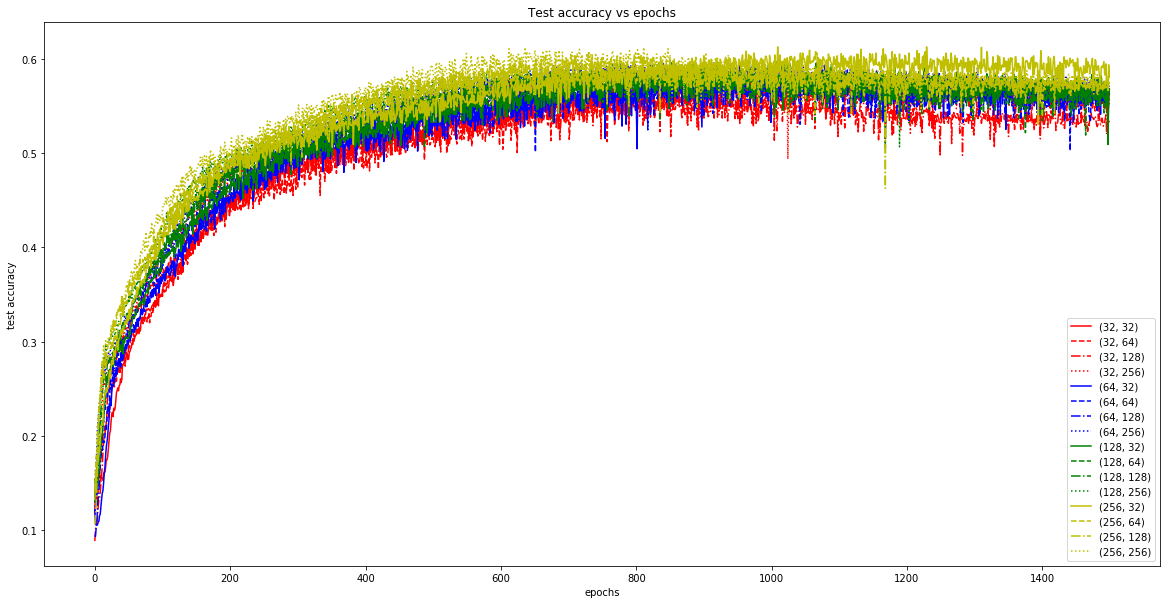

In [0]:
# Plot learning curve

plt.figure(figsize=(20,10))
plt.plot(np.arange(epochs), train_loss_all[0], 'r', linestyle='-', label = parameters[0])
plt.plot(np.arange(epochs), train_loss_all[1], 'r', linestyle='--', label = parameters[1])
plt.plot(np.arange(epochs), train_loss_all[2], 'r', linestyle='-.', label = parameters[2])
plt.plot(np.arange(epochs), train_loss_all[3], 'r', linestyle=':', label = parameters[3])
plt.plot(np.arange(epochs), train_loss_all[4], 'b', linestyle='-', label = parameters[4])
plt.plot(np.arange(epochs), train_loss_all[5], 'b', linestyle='--', label = parameters[5])
plt.plot(np.arange(epochs), train_loss_all[6], 'b', linestyle='-.', label = parameters[6])
plt.plot(np.arange(epochs), train_loss_all[7], 'b', linestyle=':', label = parameters[7])
plt.plot(np.arange(epochs), train_loss_all[8], 'g', linestyle='-', label = parameters[8])
plt.plot(np.arange(epochs), train_loss_all[9], 'g', linestyle='--', label = parameters[9])
plt.plot(np.arange(epochs), train_loss_all[10], 'g', linestyle='-.', label = parameters[10])
plt.plot(np.arange(epochs), train_loss_all[11], 'g', linestyle=':', label = parameters[11])
plt.plot(np.arange(epochs), train_loss_all[12], 'y', linestyle='-', label = parameters[12])
plt.plot(np.arange(epochs), train_loss_all[13], 'y', linestyle='--', label = parameters[13])
plt.plot(np.arange(epochs), train_loss_all[14], 'y', linestyle='-.', label = parameters[14])
plt.plot(np.arange(epochs), train_loss_all[15], 'y', linestyle=':', label = parameters[15])
plt.title('Training cost vs epochs')
plt.xlabel('epochs')
plt.ylabel('training cost')
plt.legend(loc='upper right')

plt.figure(figsize=(20,10))
plt.plot(np.arange(epochs), test_acc_all[0], 'r', linestyle='-', label = parameters[0])
plt.plot(np.arange(epochs), test_acc_all[1], 'r', linestyle='--', label = parameters[1])
plt.plot(np.arange(epochs), test_acc_all[2], 'r', linestyle='-.', label = parameters[2])
plt.plot(np.arange(epochs), test_acc_all[3], 'r', linestyle=':', label = parameters[3])
plt.plot(np.arange(epochs), test_acc_all[4], 'b', linestyle='-', label = parameters[4])
plt.plot(np.arange(epochs), test_acc_all[5], 'b', linestyle='--', label = parameters[5])
plt.plot(np.arange(epochs), test_acc_all[6], 'b', linestyle='-.', label = parameters[6])
plt.plot(np.arange(epochs), test_acc_all[7], 'b', linestyle=':', label = parameters[7])
plt.plot(np.arange(epochs), test_acc_all[8], 'g', linestyle='-', label = parameters[8])
plt.plot(np.arange(epochs), test_acc_all[9], 'g', linestyle='--', label = parameters[9])
plt.plot(np.arange(epochs), test_acc_all[10], 'g', linestyle='-.', label = parameters[10])
plt.plot(np.arange(epochs), test_acc_all[11], 'g', linestyle=':', label = parameters[11])
plt.plot(np.arange(epochs), test_acc_all[12], 'y', linestyle='-', label = parameters[12])
plt.plot(np.arange(epochs), test_acc_all[13], 'y', linestyle='--', label = parameters[13])
plt.plot(np.arange(epochs), test_acc_all[14], 'y', linestyle='-.', label = parameters[14])
plt.plot(np.arange(epochs), test_acc_all[15], 'y', linestyle=':', label = parameters[15])
plt.title('Test accuracy vs epochs')
plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.legend(loc='lower right')


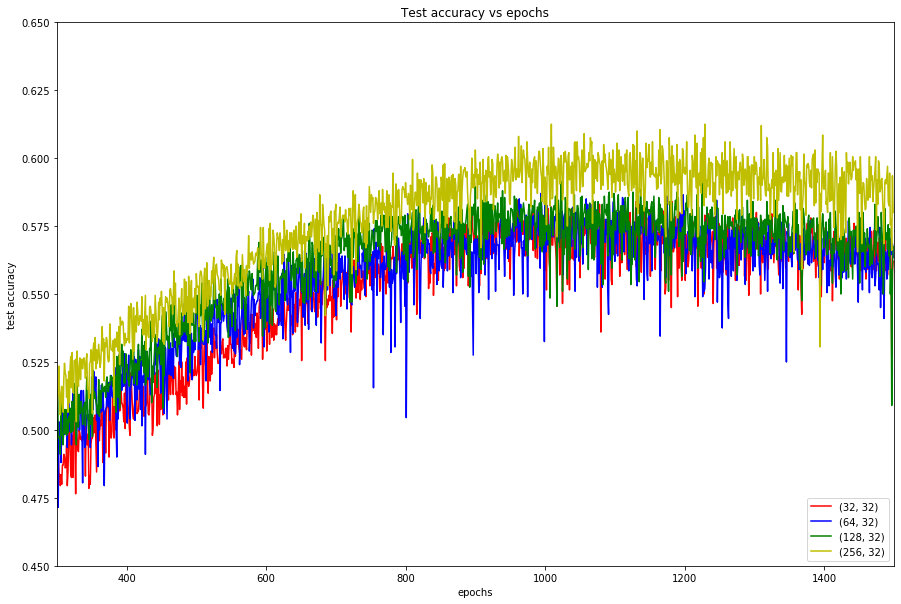

In [0]:
# The above plot is hard to compare, hence we plot separately to select the best number of filters
# filter2 = 32
plt.figure(figsize=(15,10))
plt.plot(np.arange(epochs), test_acc_all[0], 'r', linestyle='-', label = parameters[0])
plt.plot(np.arange(epochs), test_acc_all[4], 'b', linestyle='-', label = parameters[4])
plt.plot(np.arange(epochs), test_acc_all[8], 'g', linestyle='-', label = parameters[8])
plt.plot(np.arange(epochs), test_acc_all[12], 'y', linestyle='-', label = parameters[12])
plt.title('Test accuracy vs epochs')
plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.xlim((300,1500))
plt.ylim((0.45, 0.65))
plt.legend(loc='lower right')


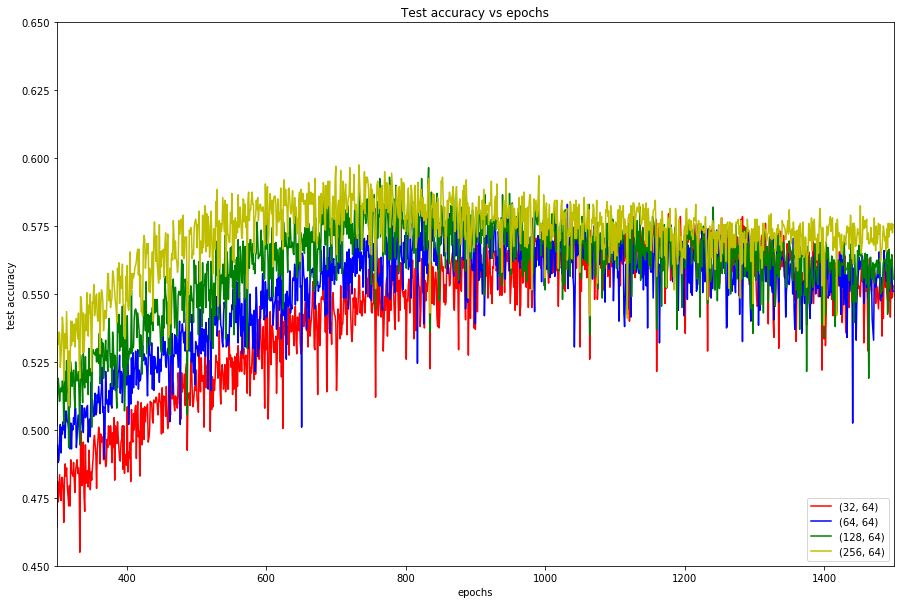

In [0]:
# filter2 = 64
plt.figure(figsize=(15,10))
plt.plot(np.arange(epochs), test_acc_all[1], 'r', linestyle='-', label = parameters[1])
plt.plot(np.arange(epochs), test_acc_all[5], 'b', linestyle='-', label = parameters[5])
plt.plot(np.arange(epochs), test_acc_all[9], 'g', linestyle='-', label = parameters[9])
plt.plot(np.arange(epochs), test_acc_all[13], 'y', linestyle='-', label = parameters[13])
plt.title('Test accuracy vs epochs')
plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.xlim((300,1500))
plt.ylim((0.45, 0.65))
plt.legend(loc='lower right')


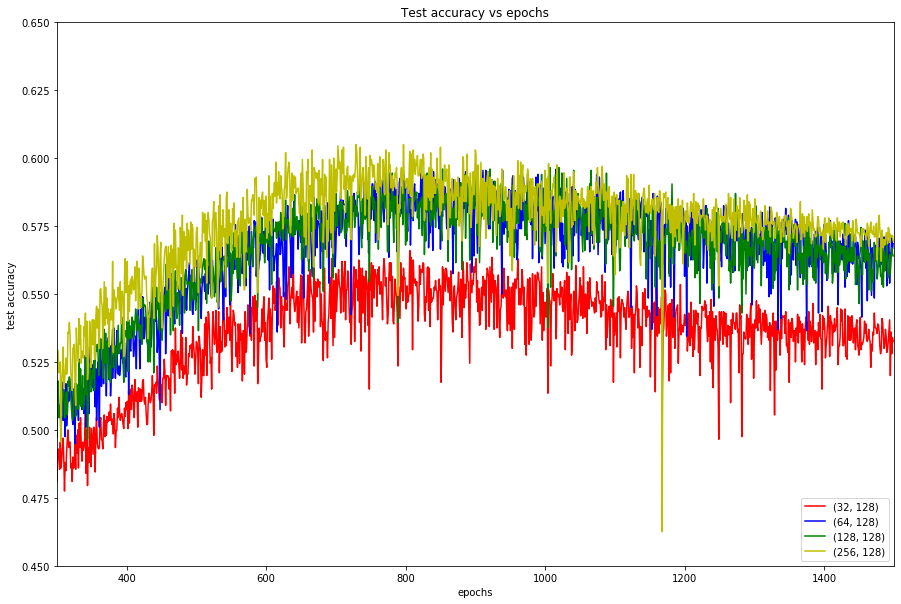

In [0]:
# filter2 = 128
plt.figure(figsize=(15,10))
plt.plot(np.arange(epochs), test_acc_all[2], 'r', linestyle='-', label = parameters[2])
plt.plot(np.arange(epochs), test_acc_all[6], 'b', linestyle='-', label = parameters[6])
plt.plot(np.arange(epochs), test_acc_all[10], 'g', linestyle='-', label = parameters[10])
plt.plot(np.arange(epochs), test_acc_all[14], 'y', linestyle='-', label = parameters[14])
plt.title('Test accuracy vs epochs')
plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.xlim((300,1500))
plt.ylim((0.45, 0.65))
plt.legend(loc='lower right')


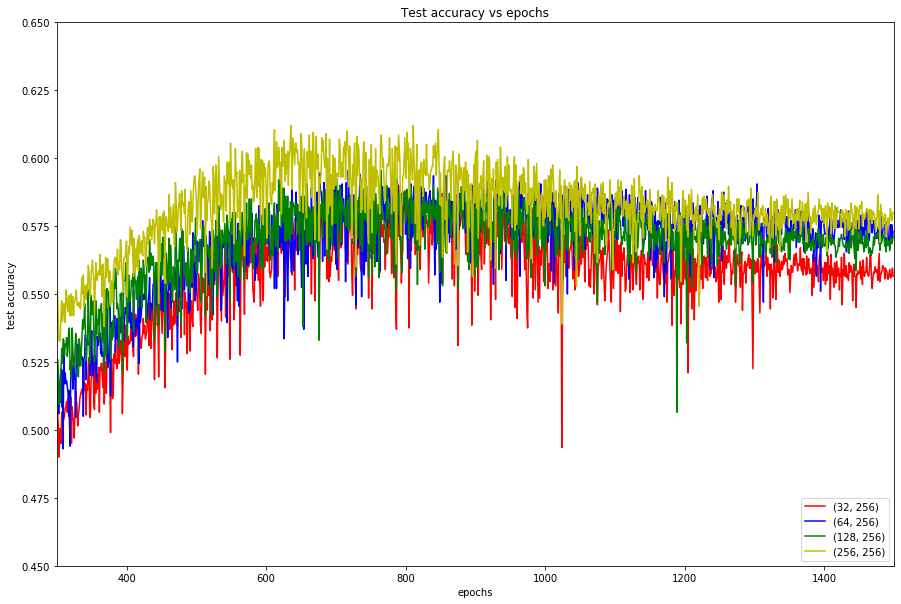

In [0]:
# filter2 = 256
plt.figure(figsize=(15,10))
plt.plot(np.arange(epochs), test_acc_all[3], 'r', linestyle='-', label = parameters[3])
plt.plot(np.arange(epochs), test_acc_all[7], 'b', linestyle='-', label = parameters[7])
plt.plot(np.arange(epochs), test_acc_all[11], 'g', linestyle='-', label = parameters[11])
plt.plot(np.arange(epochs), test_acc_all[15], 'y', linestyle='-', label = parameters[15])
plt.title('Test accuracy vs epochs')
plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.xlim((300,1500))
plt.ylim((0.45, 0.65))
plt.legend(loc='lower right')


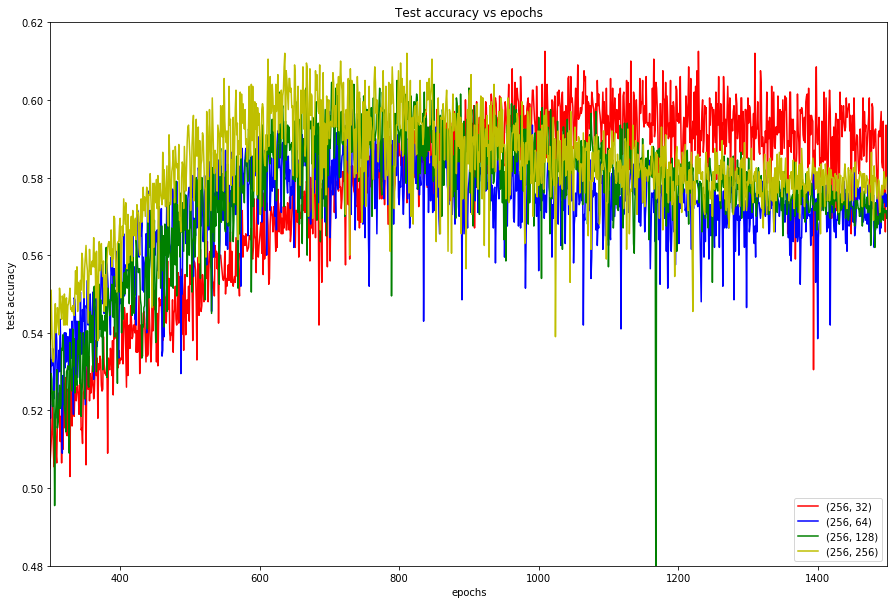

In [0]:
# Plot the best curve from each of the above 4 plots
plt.figure(figsize=(15,10))
plt.plot(np.arange(epochs), test_acc_all[12], 'r', linestyle='-', label = parameters[12])
plt.plot(np.arange(epochs), test_acc_all[13], 'b', linestyle='-', label = parameters[13])
plt.plot(np.arange(epochs), test_acc_all[14], 'g', linestyle='-', label = parameters[14])
plt.plot(np.arange(epochs), test_acc_all[15], 'y', linestyle='-', label = parameters[15])
plt.title('Test accuracy vs epochs')
plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.xlim((300,1500))
plt.ylim((0.48, 0.62))
plt.legend(loc='lower right')


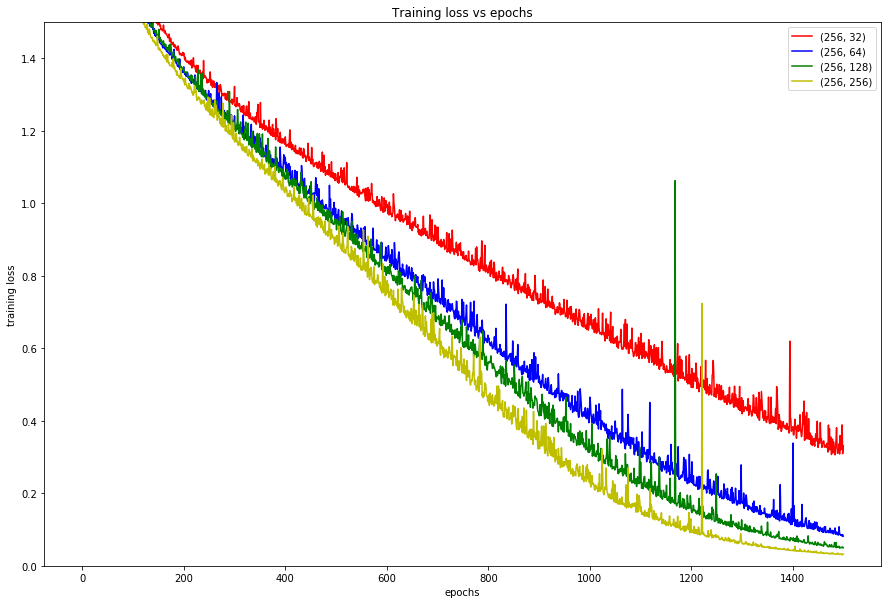

In [0]:
# Plot the training loss from each of the above 4 sets of parameters
plt.figure(figsize=(15,10))
plt.plot(np.arange(epochs), train_loss_all[12], 'r', linestyle='-', label = parameters[12])
plt.plot(np.arange(epochs), train_loss_all[13], 'b', linestyle='-', label = parameters[13])
plt.plot(np.arange(epochs), train_loss_all[14], 'g', linestyle='-', label = parameters[14])
plt.plot(np.arange(epochs), train_loss_all[15], 'y', linestyle='-', label = parameters[15])
plt.title('Training loss vs epochs')
plt.xlabel('epochs')
plt.ylabel('training loss')
#plt.xlim((300,1500))
plt.ylim((0, 1.5))
plt.legend(loc='upper right')


In [0]:
# Save the models for comparison later
train_loss_np = np.array(train_loss_all)
np.save('Qn2 train loss.npy',train_loss_np)

test_acc_np = np.array(test_acc_all)
np.save('Qn2 test acc.npy',test_acc_np)